In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline    
#正常显示画图时出现的中文和负号
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


pd.options.display.max_rows=None

In [2]:
df = pd.read_csv('res.csv')
df.drop(columns=['Unnamed: 0','reward'],inplace=True)

In [3]:
df['position'] = df['signal'].shift(1)
df['position'] = df['position'].replace({1:np.nan})
df['position'] = df['position'].replace({2:1})
df['position'].fillna(method='ffill',inplace = True)
df['position'].fillna(0,inplace=True)
df['ret'] = df['close'].pct_change()
df.loc[0,'ret']=0

In [4]:
cost = 5/10000
#根据交易信号和仓位计算策略的每日收益率
df.loc[df.index[0], 'capital_ret'] = 0
#今天开盘新买入的position在今天的涨幅(扣除手续费)
df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] = \
                         (df['close'] / df['open']-1) * (1- cost) 
#卖出同理
df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] = \
                   (df['open'] / df['close'].shift(1)-1) * (1-cost) 
# 当仓位不变时,当天的capital是当天的change * position
df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] = \
                        df['ret'] * df['position']

df['capital_line']=(df.capital_ret+1.0).cumprod()
df['index_line']=(df.ret+1.0).cumprod()

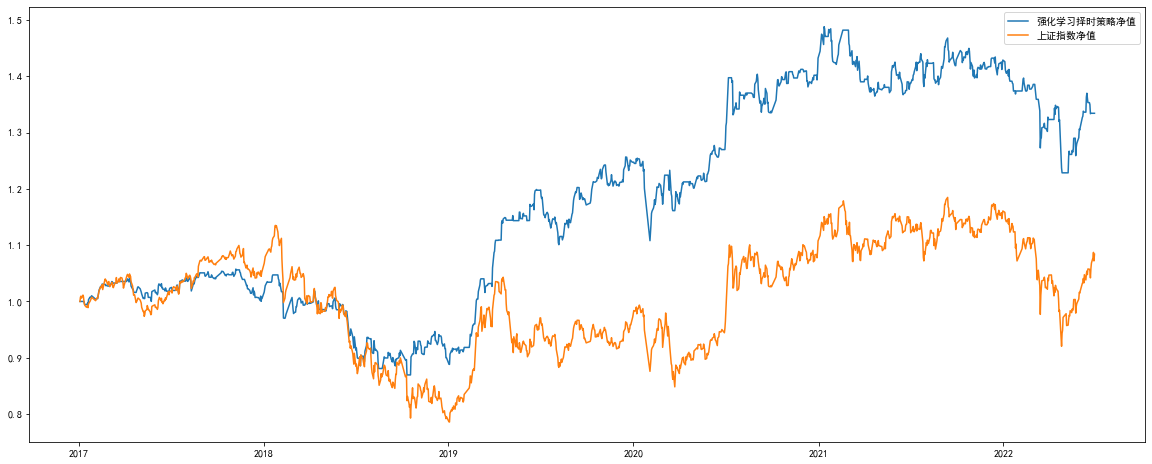

In [5]:
df.set_index(pd.to_datetime(df['trade_date']),inplace=True)

plt.figure(figsize=(20,8))
plt.plot(df['capital_line'],label='强化学习择时策略净值')
plt.plot(df['index_line'],label='上证指数净值')
plt.legend()